In [1]:
# import anything necessary
import pandas as pd
import numpy as np
import re
import math

from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from scipy.stats import norm, variation, f_oneway, pearsonr
from scipy.misc import derivative

from datetime import datetime

import warnings

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Preparation and Setup

Load data

In [2]:
# load data
step_data_initial = pd.read_csv("path_coordinates")

Apply general smoothening to avoid too much sensitivity, choose a sigma of 2 for medium smoothening to not loose information.

In [3]:
def gaussian_smooth(df, sigma=2):
    
    for column in df.columns:
        # look for all column names that contain numbers
        if re.search(r'\d', column):
            #smoothen out specified column by sigma
            df[column] = gaussian_filter1d(df[column], sigma=sigma)
            
    return df

In [4]:
step_data = gaussian_smooth(step_data_initial, sigma=2)

Print out all column names as returned by mediapipe. Note that there are two different markers for either feet: A heel marker and a 'foot_index', which is really the toe. 

In [5]:
# print all columns
print([col for col in step_data_initial.columns])

['nose_x', 'nose_y', 'nose_z', 'left_eye_inner_x', 'left_eye_inner_y', 'left_eye_inner_z', 'left_eye_x', 'left_eye_y', 'left_eye_z', 'left_eye_outer_x', 'left_eye_outer_y', 'left_eye_outer_z', 'right_eye_inner_x', 'right_eye_inner_y', 'right_eye_inner_z', 'right_eye_x', 'right_eye_y', 'right_eye_z', 'right_eye_outer_x', 'right_eye_outer_y', 'right_eye_outer_z', 'left_ear_x', 'left_ear_y', 'left_ear_z', 'right_ear_x', 'right_ear_y', 'right_ear_z', 'mouth_left_x', 'mouth_left_y', 'mouth_left_z', 'mouth_right_x', 'mouth_right_y', 'mouth_right_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x', 'right_elbow_y', 'right_elbow_z', 'left_wrist_x', 'left_wrist_y', 'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z', 'left_pinky_x', 'left_pinky_y', 'left_pinky_z', 'right_pinky_x', 'right_pinky_y', 'right_pinky_z', 'left_index_x', 'left_index_y', 'lef

Translate the time stamp into usable timedelta format and change to mil seconds.

In [6]:
# create function to transform time in miliseconds to total seconds
def timedelta_to_milliseconds(td):
    return int(round(td.total_seconds() * 1000))

In [7]:
# create functional copy of original dataframe to avoid fracmentation error
#step_data = step_data.copy()

# convert string time stamp to timedelta 
#step_data['_time'] = pd.to_timedelta(step_data['_time'])

# convert timedelta to milliseconds
#step_data['_time_mil_seconds'] = step_data['_time'].apply(timedelta_to_milliseconds)

And finally, create functioning copy of the data to avoid fragmentation errors.

In [8]:
df = step_data_initial.copy()

In [9]:
step_data = step_data_initial.copy()

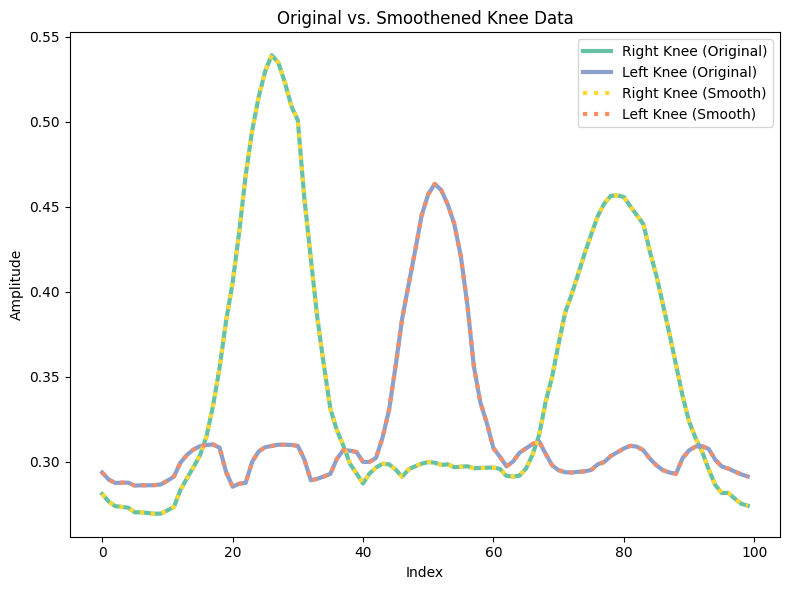

In [10]:
# reduce data to first 100 indices
df_plot = df.iloc[:100]
step_plot = step_data_initial.iloc[:100]

# set colouring and figure dimensions
palette = sns.color_palette("Set2")
plt.figure(figsize=(8, 6))

# plot original data using solid lines
plt.plot(df_plot.index, step_plot['right_knee_y'], color=palette[0], label='Right Knee (Original)', linestyle='-', linewidth=3)
plt.plot(df_plot.index, step_plot['left_knee_y'], color=palette[2], label='Left Knee (Original)', linestyle='-', linewidth=3)

# ... and the smoothened data using dotted lines
plt.plot(df_plot.index, df_plot['right_knee_y'], color=palette[5], label='Right Knee (Smooth)', linestyle=':', linewidth=3)
plt.plot(df_plot.index, df_plot['left_knee_y'], color=palette[1], label='Left Knee (Smooth)', linestyle=':', linewidth=3)

# add labels, legend and title
plt.xlabel('Index')
plt.ylabel('Amplitude')
plt.title('Original vs. Smoothened Knee Data')
plt.legend()

# adjust layout
plt.tight_layout()

# and save to png
plt.savefig('comparison_data_smoothed.png')

plt.show()


# Tracking Steps

Obtain knee threshold be selecting the global minimum of the right foot, this must be the point in time, where the test takers' right leg is most extended. Then proceed to mathematically obtain middle between right knee and hip, which is the commonly selected threshold of the 2MST. 

In [11]:
def find_knee_threshold(df):
    
    # find global minimum of right foot
    min_right_foot_y = df['right_foot_index_y'].min()
    
    # obtain index value for this global minimum
    min_right_foot_index = df['right_foot_index_y'].idxmin()

    # select right knee and hip coordinates for selected index
    right_knee_y_at_min_right_foot = df.at[min_right_foot_index, 'right_knee_y']
    right_hip_y_at_min_right_foot = df.at[min_right_foot_index, 'right_hip_y']

    # compute threshold marker based on knee and hip coordinates
    threshold_marker_y = (right_knee_y_at_min_right_foot + right_hip_y_at_min_right_foot) / 2
    
    # display results
    print("Threshold marker position (Y):", threshold_marker_y)
    
    return threshold_marker_y

In [12]:
# obtain threshold marker
knee_threshold = find_knee_threshold(df)

Threshold marker position (Y): 0.3867803514003753


## Velocity and Ground Detection

In [13]:
def plot_ground_contact(data, marker_column, time_column, ground_contact_column, lower_bound, upper_bound):
    
    # use 2nd colour palette from seaborn for consistency
    sns.set_palette("Set2")
    palette = sns.color_palette()
    
    # choose colour for the position/y-marker
    position_color = palette[0]
    # and choose colour for ground segments
    contact_color = palette[5]
    
    # set figure dimensions
    plt.figure(figsize=(12, 6))

    # iterate through data assign plot segments
    for i in range(len(data) - 1):
        # ... and assign colour dependent on segment type
        if data[ground_contact_column].iloc[i]:
            # if value for ground_contact = True:
            color = contact_color
            # else, not ground_contact = False
        else:
            color = position_color
        
        # and plot the segment
        plt.plot(data[time_column].iloc[i:i+2], data[marker_column].iloc[i:i+2], color=color)

    # draw in line of upper ground CI
    plt.axhline(y=upper_bound, color=palette[1], linestyle='--', label='Ground CI Upper Bound')
    
    # set labels and title
    plt.xlabel('Time (milliseconds)')
    plt.ylabel('Foot Y-Coordinate')
    plt.title('Foot Position Over Time with Ground Contact Highlighted')

    # add legend
    plt.legend()
    
    # save image to png
    plt.savefig(f"Ground_contact_{marker_column}_over_time.png")
    
    plt.show()


Function to find and obtain all knee peaks. Moved up due to call in dynamic foot threshold!

In [14]:
def revised_find_peaks(df, marker, threshold, dist):
    
    # select knees
    right_knee_pos = df[marker]
    
    # obtain local maxima for both knees
    right_peaks, _ = find_peaks(right_knee_pos, height=threshold, distance=dist)
    
    return right_peaks

Define a function to find all local feet minima - but make sure to only include those that lie below an initial height-threshold of the respective ankle marker as some dataframes have shown atypical heights for foot movement, that included several peaks and minima during the foot's time in the air that should not be considered for an interval of ground_height.

In [15]:
def find_all_minima(data, marker, ankle_marker):
    
    # invert the data for the selected marker to easily detect local minima 
    inverted_data = -data[marker]
    minima_indices, _ = find_peaks(inverted_data)
    minima_values = data[marker].iloc[minima_indices]
    
    # obtain the mean height of the ankle as threshold - do not just take first value, but mean over all values to avoid missing an offset between sides!
    initial_ankle_marker_height = np.mean(data[ankle_marker])
    
    # use this knee-cutoff_threshold to only include minima below the initial knee marker height
    valid_minima_indices = minima_indices[minima_values <= initial_ankle_marker_height]
    valid_minima_values = minima_values[minima_values <= initial_ankle_marker_height]
    
    return valid_minima_indices, valid_minima_values

And define function to find greatest minimum which will be used for the upper ground interval bound.

In [16]:
def get_highest_minima(minima_values):
    return minima_values.max()

But just inspecting the height of the foot minima might not be sufficient as some development dataframes have shown the foot marker's coordinates to be greater in magnitude over the active movement section of the data, likely because the test takers' leg is more extended during the test. This is why I will additionally include the data of the first 3 seconds to assess a potential offset between inactive and active phases of the data, otherwise, the ground contact during the first seconds might be missed.

In [17]:
def inspect_initial_stance(data, knee_peaks, marker, time_limit=3):
    
    # inspect and obtain all data before the first knee peak (signaling begin of active phase) or until 3 seconds have passed
    if knee_peaks.size == 0 or data['timestamp_seconds'].iloc[knee_peaks[0]] > time_limit:
        initial_data = data[data['timestamp_seconds'] <= time_limit]
        return initial_data[marker].min()
    
    return None

In [18]:
def create_ground_contact_interval(data, marker, knee_marker, knee_peaks, time_limit=3):
    
    # obtain all local foot minima
    minima_indices, minima_values = find_all_minima(data, marker, knee_marker)
    # ... and select the minimum of greatest magnitude
    highest_minima = get_highest_minima(minima_values)
    
    # inspect data of first 3 seconds or until the first knee peak indicates beginning of active phase
    initial_position = inspect_initial_stance(data, knee_peaks, marker, time_limit)
    
    # set range of interval indicating ground contact, and first check if inactive phase at beginning is greater in magnitude than active phase
    if initial_position is not None:
        ground_contact_upper = max(highest_minima, initial_position)
    else:
        ground_contact_upper = highest_minima
    
    # select lowest value possible as fixed lower bound, currently y coordinates are standardized between 0 and 1
    ground_contact_lower = 0
    
    return ground_contact_lower, ground_contact_upper

In [19]:
def detect_ground_contact(data, marker, lower_bound, upper_bound, percentile):
    #"""
    #returns boolean indicating False for foot being lifted and True for foot placed on ground
    #"""
    
    #set names for new columns
    vel_name = f"velocity_{marker}"
    
    # compute velocity for y-coordinate of right foot
    velocity_y = np.gradient(data[marker], data['timestamp_seconds'])
    data.loc[:, vel_name] = velocity_y
    
    # compute velocity threshold based on 95. percentile to obtain a threshold that is capable of dealing with uncertainty
    velocity_threshold = np.percentile(np.abs(velocity_y), percentile)
    
    # detect ground contact based only on the defined bounds
    ground_contact =  (data[marker] >= lower_bound) & (data[marker] <= upper_bound) | (np.abs(velocity_y) < velocity_threshold)
    
    # store ground contact column
    data.loc[:, f'ground_contact_{marker}'] = ground_contact
    
    return ground_contact

And now, obtain dynamic thresholds for the left foot.

In [20]:
# obtain knee peaks to visualize ground contact
knee_peaks_right = revised_find_peaks(step_data, 'right_knee_y', threshold=knee_threshold, dist=30)
knee_peaks_left = revised_find_peaks(step_data, 'left_knee_y', threshold=knee_threshold, dist=30)

In [21]:
# compute ground interval for left foot using list of left knee peaks and the left ankle marker
left_ground_lower, left_ground_upper = create_ground_contact_interval(step_data, 'left_foot_index_y', 'left_ankle_y', knee_peaks_left)
print(f"Ground Contact Interval: Lower Bound = {left_ground_lower}, Upper Bound = {left_ground_upper}")

Ground Contact Interval: Lower Bound = 0, Upper Bound = 0.1580269932746887


In [22]:
# obtain moments of ground contact for left foot 
ground_contact_left = detect_ground_contact(step_data, 'left_foot_index_y', left_ground_lower, left_ground_upper, 0.05)

In [23]:
def plot_ground_contact(data, marker_column, ground_contact_column, upper_bound):
    
    # select 2nd seaborn predefined colour palette
    sns.set_palette("Set2")
    palette = sns.color_palette()

    # select colour for air-time
    position_color = palette[0]
    # select for ground contact
    contact_color = palette[5]

    # set figure dimensions
    fig, ax = plt.subplots(figsize=(12, 6))

    # draw y-coordinates of foot movement over time and shift to background
    plt.plot(data['frame_number'], data[marker_column], color='lightgrey', label='Foot Movement', zorder=1)

    # place marker points for each frame and use ground-contact-check to apply colouring
    colors = [contact_color if y <= upper_bound else position_color for y in data[marker_column]]
    plt.scatter(data['frame_number'], data[marker_column], c=colors, s=30, label='Grund Contact Status')

    # draw upper ground contact interval line
    plt.axhline(y=upper_bound, color=palette[1], linestyle='--', label='Ground Contact CI Upper Bound')

    # set labels and title
    plt.xlabel('Frame Number')
    plt.ylabel(f'{marker_column}')
    plt.title(f'{marker_column} Position Over Time with Ground Contact Highlighted')

    # add legend and place outside the plot, then adjust layout
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()

    # save to png
    plt.savefig(f"Ground_contact_{marker_column}_line_points.png")

    plt.show()

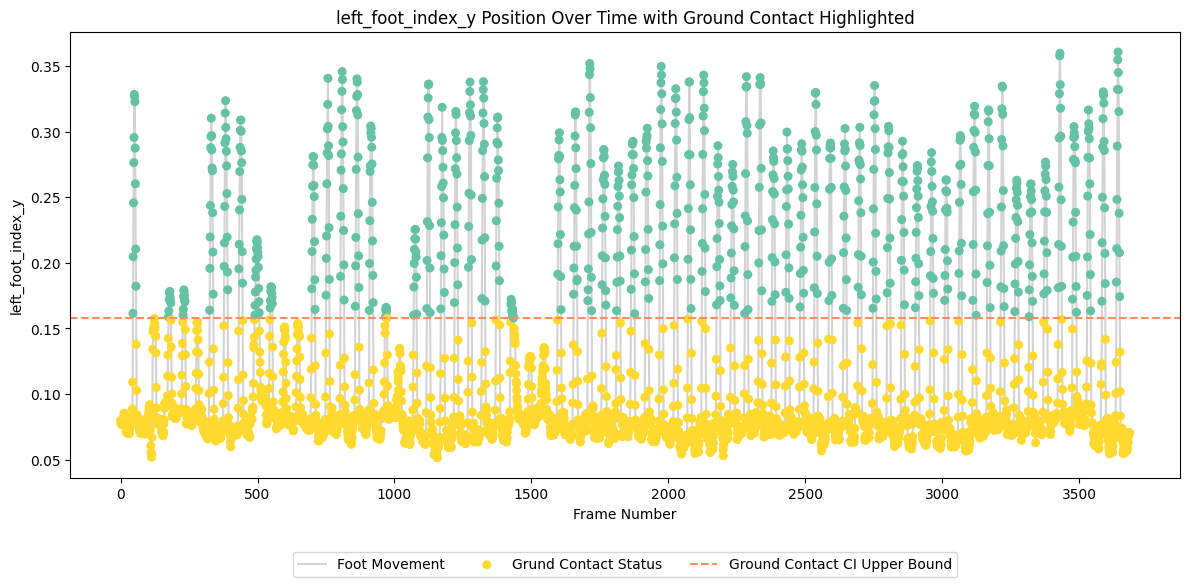

In [24]:
plot_ground_contact(step_data, 'left_foot_index_y', 'ground_contact_left_foot_index_y', left_ground_upper)

And right foot.

In [25]:
# obtain ground interval for right foot, using the list containing indices of right knee peaks and the right ankle marker
right_ground_lower, right_ground_upper = create_ground_contact_interval(step_data, 'right_foot_index_y', 'right_ankle_y', knee_peaks_right)
print(f"Ground Contact Interval: Lower Bound = {right_ground_lower}, Upper Bound = {right_ground_upper}")

Ground Contact Interval: Lower Bound = 0, Upper Bound = 0.1148880124092102


In [26]:
# and obtain ground contact for right foot
ground_contact_right = detect_ground_contact(step_data, 'right_foot_index_y', right_ground_lower, right_ground_upper, 0.05)

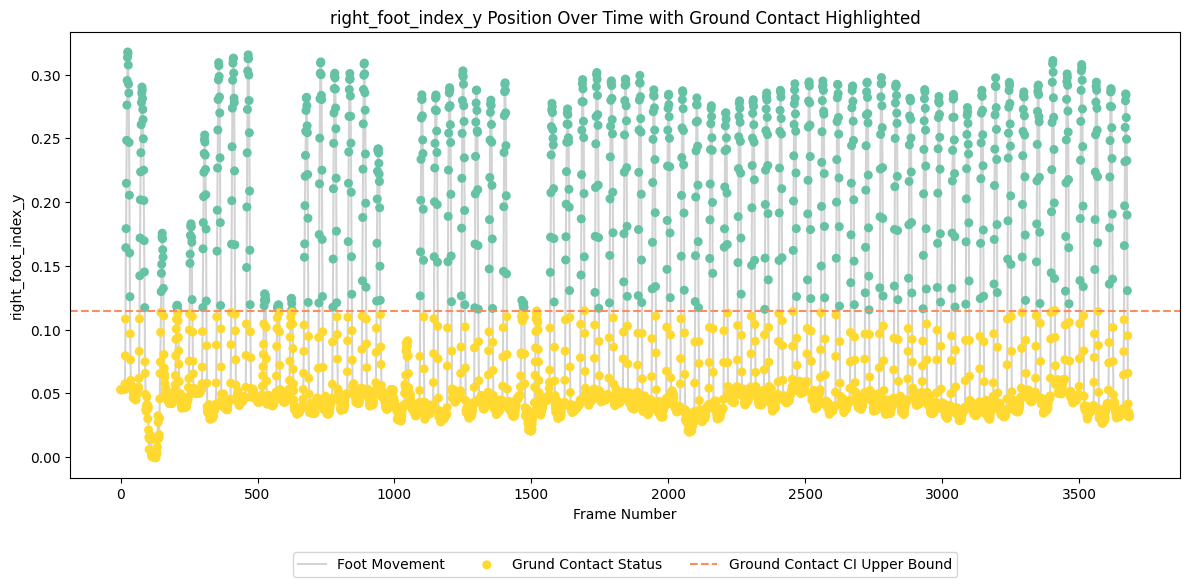

In [27]:
# test by visualization
plot_ground_contact(step_data, 'right_foot_index_y', 'ground_contact_right_foot_index_y', right_ground_upper)

Data points for which the foot is considered to be lifted and moved while the respective knee and leg are moving are coloured green, whereas data points for which the foot is placed solidly on the ground are coloured in yellow.

# Step Analysis

In [28]:
def validate_step_sequence(df, peaks_right_knee, peaks_left_knee, is_last=False):
    # initialize empty results list
    valid_sequences = []

    # start counter at 0
    i = 0
    while i < len(peaks_right_knee):
        
        # select current right knee peak
        right_peak = peaks_right_knee[i]
        
        # get the next right knee peak if available
        next_right_peak = peaks_right_knee[i+1] if i+1 < len(peaks_right_knee) else None
        
        # look for left peaks after current right peak
        left_peak_candidates = [peak for peak in peaks_left_knee if peak > right_peak]
        
        # if there are no left peaks after the current right peak left, break
        if not left_peak_candidates:
            break
        
        # select first left peak after the right peak
        left_peak = left_peak_candidates[0]
        
        # check if next right peak comes before the selected left peak
        if next_right_peak and next_right_peak < left_peak:
            
            # if yes, sequence is invalid, increment counter and skip peak
            i += 1
            continue
        
        # assess if valid ground contact for left foot between right_peak and left_peak
        if df['ground_contact_left_foot_index_y'].iloc[right_peak:left_peak].any():
            
            # store all following right-knee-peaks
            next_right_candidates = [peak for peak in peaks_right_knee if peak > left_peak]
            
            # and if not empty, select the first valid right-knee-peak
            if next_right_candidates:
                next_right_peak = next_right_candidates[0]
                
                # and assess if valid ground contact for right foot between left_peak and the next right_peak
                if df['ground_contact_right_foot_index_y'].iloc[left_peak:next_right_peak].any():
                    # if both conditions are met, it’s a valid step!
                    valid_sequences.append((right_peak, left_peak))
            else:
                
                if is_last:
                    # and make sure to not miss final step at end/last segment!
                    valid_sequences.append((right_peak, left_peak))
                else: 
                    break
        
        # increment counter to move to the next right peak
        i += 1

    # obtain count of all valid steps taken
    valid_count = len(valid_sequences)

    print(f"Valid steps with ground contact: {valid_count}")

    return valid_sequences, valid_count


In [29]:
# test on entire data
valid_steps, valid_step_count = validate_step_sequence(
    step_data, 
    knee_peaks_right, 
    knee_peaks_left,
    is_last = True
)

Valid steps with ground contact: 59


This works, apparently, one step is missing here - might be due to oversensitivity? 

## Cross-Body-Coordination using Arm Movement

In [30]:
# set hand threshold so that every hand peak will be considered a success
hand_threshold = 0  # lowest value possible ;) 

In [31]:
# full hand peaks
peaks_right_hand = revised_find_peaks(step_data, 'right_wrist_y', threshold=hand_threshold, dist=25)
peaks_left_hand = revised_find_peaks(step_data, 'left_wrist_y', threshold=hand_threshold, dist=25)

In [32]:
def revised_step_sequence_analysis_with_arm_coordination(df, sequences, peaks_right_hand, peaks_left_hand, time_window):

    # similar to the original function, start by setting up an empty list to store time stamps for cross-body coordination in
    coordinated_sequences = []
    # and set counter to 0
    correct_coordination_count = 0

    # then process the list of correct step-sequences and obtain the time stamps for each index number
    for right_peak, left_peak in sequences:
        right_peak_time = df['timestamp_seconds'].iloc[right_peak]
        left_peak_time = df['timestamp_seconds'].iloc[left_peak]

        # then search for any pre-searched local maximum that lies within a specified time window around the knee-peak time-stamp
        right_hand_within_window = [ph for ph in peaks_right_hand if abs(df['timestamp_seconds'].iloc[ph] - left_peak_time) <= time_window]
        left_hand_within_window = [ph for ph in peaks_left_hand if abs(df['timestamp_seconds'].iloc[ph] - right_peak_time) <= time_window]

        # then increase counter per identified cross-body coordination and append indices to list from above
        if right_hand_within_window and left_hand_within_window:
            correct_coordination_count += 1
            coordinated_sequences.append((right_peak, left_peak))

    # print out results
    print(f"{len(sequences)} steps counted with {correct_coordination_count} correct arm-leg coordination.")

    return coordinated_sequences, len(coordinated_sequences), correct_coordination_count


# Consistency Analysis

**IDEA:** How consistent is a participant performing? Is the overall consistency reflected in the number of successful steps in a row? Or in the hight of the knee-peaks? Later on during the scoring, this will be used as a penality

I would suspect both to be relevant: If a person achieves check-marks for correct sequences without missing steps and if the peaks indicating that the knees were lifted high enough are of similar height for each knee, then the person moves with little variation and is thus consistent.  

**How to track?**

1) Divide the entire time into 4 segements of 30 seconds each

2) Compute the standard deviation between successful steps, steps with correct cross-body-coordination and knee-peak-height

3) Obtain overall measure of consistency, and three individual values

In [33]:
# collect height of peaks for left and right knee and store as 'amplitudes'

def calculate_amplitude_features(df, peaks_right, peaks_left):
    
    # process the lists containing the indeces for the right and left peaks and obtain the y-coordinates from the dataframe
    right_amplitudes = df['right_knee_y'].iloc[peaks_right].values
    left_amplitudes = df['left_knee_y'].iloc[peaks_left].values
    
    return right_amplitudes, left_amplitudes

In [34]:
# compute the variation across these heights by obtaining the standard deviation

def calculate_peak_variation(amplitudes):

    # check if list 'apmlitudes' is empty and if yes return NaN
    if len(amplitudes) == 0:
        return np.nan
    
    return np.std(amplitudes)

Now, all three steps are combined into one workflow: 

1) Preprocess data by:

- applying Gauss-Smoothening with sigma set to 2
- changing data type of 'timestamp' to a workable format (both usable as seconds and milliseconds)
- no further cleaning required as there are no missing/corrupted values after coordinate-estimation

2) Split data into 4 segments of 30 seconds each and then:

- compute number of steps that were executed correctly
- compute number of steps that additionally show good posture via cross-body coordination
- obtain amplitdues/height of knee-lifts for both knees

3) Compute overall consistency of movement for all three measures and a composite consistency-score

In [35]:
def calculate_frames_between_peaks(df, peaks_right_knee, peaks_left_knee):
    
    # obtain the timestamps of right knee peaks
    right_peak_times = df['timestamp_seconds'].iloc[peaks_right_knee]
    # and take difference
    time_between_right_peaks = np.diff(right_peak_times)
    
    # obtain timestamps of left knee peaks
    left_peak_times = df['timestamp_seconds'].iloc[peaks_left_knee]
    # and take difference
    time_between_left_peaks = np.diff(left_peak_times)
    
    # store results
    frames_between_peaks = {
        'time_between_right_peaks': time_between_right_peaks,
        'time_between_left_peaks': time_between_left_peaks
    }
    
    return frames_between_peaks


In [36]:
def detect_breaks(df, break_threshold=3):
    
    # initialize break counter and set to 0
    break_counter = 0
    
    # initialize empty list to store results in
    breaks_frames = []

    # initialize variables to indicate when a person takes a break...
    is_breaking = False
    # when the break began...
    break_start_time = None
    # and a running list to store the frame numbers of when the break began
    break_frames = []
    
    # iterate over data
    for i, row in df.iterrows():
        
        # obtain time and frame
        timestamp = row['timestamp_seconds']
        frame_number = row['frame_number']
        
        # and check ground contact status if both feet
        if row['ground_contact_left_foot_index_y'] and row['ground_contact_right_foot_index_y']:
            # in case of a potential start of a break
            if not is_breaking:
                # set is_breaking to True
                is_breaking = True
                # collect first frame number of potential break
                break_start_time = timestamp
                # add to frame-list
                break_frames = [frame_number]
                
            # if the person is still not moving their feet out of the ground contact zone (break continues):
            else:
                # continue to append breaks to frame-list
                break_frames.append(frame_number)
                
        else:
            # in case of break ending (one foot is no longer placed on the ground)
            if is_breaking:
                # check duration of break by subtracting start-time from current-time
                duration = timestamp - break_start_time
                # then check if break is at least as long as minimum break duration
                if duration >= break_threshold:
                    # if yes, the test taker took a break and break counter is incremented by 1
                    break_counter += 1
                    # last frame of break is extended to break-results list
                    breaks_frames.extend(break_frames)
                    
                # set all break tracking variables 
                is_breaking = False
                break_start_time = None
                break_frames = []

    # and track edge case where break is at the end of the data
    if is_breaking:
        # check duration of break by checking last timestamp and comparing to break_start_time
        duration = df.iloc[-1]['timestamp_seconds'] - break_start_time
        # if longer than break-duration...
        if duration >= break_threshold:
            #... increment counter 
            break_counter += 1
            # and extend breaks-result list
            breaks_frames.extend(break_frames)
    
    return break_counter, breaks_frames

In [37]:
breaks_count, breaks_frames = detect_breaks(step_data, break_threshold=3.0)

print(f"Number of breaks: {breaks_count}")
print(f"Frames during breaks: {breaks_frames}")

Number of breaks: 2
Frames during breaks: [973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998, 999, 1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066, 1067, 1068, 1069, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 

Let's try a different workflow where we go over the entire dataset first and then move on to the segmentation

# Segmentation Analysis

To correctly consider the segmentation, I updated the splitting function that splits up the entire data into four different segments. This function now considers a buffer that uses all local maxima of the right knee - even those that are not considered valid knee peaks, which would have to surpass the knee-threshold. All right knee peaks are used to not distort the buffer by overlooking attempts at lifting the knee properly - if those peaks are not included, the buffer will be overestimated! 

In [38]:
def find_segment_buffer(data):
    
    # obtain local maxima for both knees
    right_peaks, _ = find_peaks(data['right_knee_y'], height=data['right_ankle_y'].iloc[0], distance=30)
    
    # obtain number of frames between each knee peak
    right_foot_air_durations = np.diff(right_peaks)
    
    # and compute the mean and sd
    average_air_time = np.mean(right_foot_air_durations)
    sd_air_time = np.std(right_foot_air_durations)
    
    # and round average air time up to closest integer
    buffer = math.ceil(average_air_time + sd_air_time)
    
    return buffer

In [39]:
examp = find_segment_buffer(step_data)
print(examp)

57


And for diagnostic purposes, all splitting indices will be stored using this function, which applies a buffering system to make sure that all valid steps are detected, even over segments should a step being in one segment and end in another. 

In [40]:
def split_data_into_segments(data, peaks_right_knee, peaks_left_knee, num_segments=4):
    
    # set buffer based on average time of right foot in the air
    buffer = find_segment_buffer(data)
    
    # obtain size of the segments to make them equal
    segment_size = len(data) // num_segments
    
    # initialize empty list to store results in
    segments = []
    segment_indices = []
    
    # iterate through all segments
    for i in range(num_segments):
        
        # start index of each segment is end of previous segment + buffer
        start_idx = max(0, i * segment_size - buffer) if i > 0 else 0
        
        # start index without the buffer for debugging
        non_buffered_start_idx = i * segment_size
        
        # end index for the first 3 segments based on num_segments division
        if i < 3:
            end_idx = min(len(data), (i + 1) * segment_size)
        
        # make sure, end index for last segment includes all last frames so set equal to length of data!
        else:
            end_idx = len(data)
        
        # and use indices to save segments
        segment = data.iloc[start_idx:end_idx]
        
        # and append to segments-list
        segments.append(segment)
        
        # append indices to indices-listof shape with four tuples, once for each segment [(start without buffer, start with buffer, end)]
        segment_indices.append((non_buffered_start_idx, start_idx, end_idx))
    
    return segments, segment_indices


And define a function to just analyse the individual segments using the same workflow from above:

In [41]:
def analyze_segment(segment, knee_threshold, distance, hand_threshold, is_last=False, time_window=200):
    
    # initialize empty results dictionary
    results = {}

    # obtain all knee peaks for left and right foot per segment
    peaks_right = revised_find_peaks(segment, 'right_knee_y', threshold=knee_threshold, dist=distance)
    peaks_left = revised_find_peaks(segment, 'left_knee_y', threshold=knee_threshold, dist=distance)
    
    # compute dynamic ground intervals per segment
    left_ground_lower, left_ground_upper = create_ground_contact_interval(segment, 'left_foot_index_y', 'left_ankle_y', peaks_left)
    right_ground_lower, right_ground_upper = create_ground_contact_interval(segment, 'right_foot_index_y', 'right_ankle_y', peaks_right)
    
    # detect ground contact for both feet per segment
    ground_contact_left = detect_ground_contact(segment, 'left_foot_index_y', left_ground_lower, left_ground_upper, 0.05)
    ground_contact_right = detect_ground_contact(segment, 'right_foot_index_y', right_ground_lower, right_ground_upper, 0.05)
    
    # check for step sequences using the ground contact requirements
    sequences, num_steps = validate_step_sequence(segment, peaks_right, peaks_left, is_last)
    
    # obtain all hand peaks for cross-body-coordination
    peaks_right_hand = revised_find_peaks(segment, 'right_wrist_y', threshold=hand_threshold, dist=25)
    peaks_left_hand = revised_find_peaks(segment, 'left_wrist_y', threshold=hand_threshold, dist=25)
    
    # and perform cross-body coordination analysis
    _, num_correct_sequences, correct_coordination_count = revised_step_sequence_analysis_with_arm_coordination(
        segment,
        sequences,
        peaks_right_hand,
        peaks_left_hand,
        time_window=0.2
    )
    
    # obtain height of knee peak amplitud per segment and store as features 
    right_amplitudes, left_amplitudes = calculate_amplitude_features(segment, peaks_right, peaks_left)
    
    # compute variation in height of knee peaks for consistency analysis
    right_variation = calculate_peak_variation(right_amplitudes)
    left_variation = calculate_peak_variation(left_amplitudes)
    
    # check the time between knee peaks 
    time_between_peaks = calculate_frames_between_peaks(df, knee_peaks_right, knee_peaks_left)
    
    # and detect breaks where no steps were taken within 3 seconds
    breaks_count, breaks_frames = detect_breaks(segment, break_threshold=3.0)
    
    # store results per segment
    results['num_steps'] = num_steps
    results['correct_coordination'] = correct_coordination_count
    results['right_amplitudes'] = right_amplitudes
    results['left_amplitudes'] = left_amplitudes
    results['right_variation'] = right_variation
    results['left_variation'] = left_variation
    results['time_between_right_peaks'] = time_between_peaks['time_between_right_peaks']
    results['time_between_left_peaks'] = time_between_peaks['time_between_left_peaks']
    results['num_breaks'] = breaks_count
    results['break_frames'] = breaks_frames
    
    # set figure dynamics
    fig, ax = plt.subplots(figsize=(12, 6))

    # plot movement of y-coordinate of right and left knee data
    ax.plot(segment['right_knee_y'].reset_index(drop=True), label='Right Knee', color='blue', alpha=0.5)
    ax.plot(segment['left_knee_y'].reset_index(drop=True), label='Left Knee', color='green', alpha=0.5)

    # and place markers on peaks using relative indices (since segments start at index 0!!)
    ax.scatter(peaks_right, segment['right_knee_y'].iloc[peaks_right], color='red', label='Right Knee Peaks', zorder=3)
    ax.scatter(peaks_left, segment['left_knee_y'].iloc[peaks_left], color='orange', label='Left Knee Peaks', zorder=3)
    
    # add knee threshold to check valid knee peaks 
    plt.axhline(y=knee_threshold, color='red', linestyle='--', label=f'Threshold marker = {knee_threshold:.2f}')

    # overlay paired steps to check valid steps by connectung right to left knee peaks
    for seq in sequences:
        right_peak, left_peak = seq[0], seq[1]
        ax.plot([right_peak, left_peak], 
        [segment['right_knee_y'].iloc[right_peak], segment['left_knee_y'].iloc[left_peak]], 
        color='purple', linestyle='-', marker='o', label='Paired Step' if seq == sequences[0] else "", zorder=4)

    # add labels and legend
    ax.set_title('Knee Peaks and Paired Steps for Segment')
    ax.set_xlabel('Relative Time within Segment')
    ax.set_ylabel('Knee Amplitude')
    ax.legend()

    # save to png
    plt.savefig("segment_analysis_step_overview.png")
    
    plt.show()

    return results

In [42]:
def plot_entire_dataframe(df, right_knee_peaks, left_knee_peaks, knee_threshold, segment_indices, valid_sequences):
    
    # set Seaborn color palette
    palette = sns.color_palette("Paired")
    
    # assign colors from the palette
    right_knee_color = palette[1]  # blue
    left_knee_color = palette[3]   # green
    right_peak_color = palette[1]  # blue
    left_peak_color = palette[3]   # green
    knee_threshold_color = palette[5]  # red
    segment_start_color = palette[8]  # grayish
    buffer_color = palette[9]  # purple
    segment_end_color = 'red'   # reddish
    valid_step_color = palette[2]  # light green for valid steps
    break_color = palette[4] # light red
    
    # set figure and axis dimensions
    fig, ax = plt.subplots(figsize=(20, 6))

    # draw y-coordinate of right and left knee coordinates
    ax.plot(df['right_knee_y'].reset_index(drop=True), label='Right Knee', color=right_knee_color, alpha=0.5)
    ax.plot(df['left_knee_y'].reset_index(drop=True), label='Left Knee', color=left_knee_color, alpha=0.5)

    # place round marker pins on peaks
    ax.scatter(right_knee_peaks, df['right_knee_y'].iloc[right_knee_peaks], color=right_peak_color, label='Right Knee Peaks', zorder=3)
    ax.scatter(left_knee_peaks, df['left_knee_y'].iloc[left_knee_peaks], color=left_peak_color, label='Left Knee Peaks', zorder=3)

    # draw horizontal line for knee threshold
    plt.axhline(y=knee_threshold, color=knee_threshold_color, linestyle='--', label=f'Knee-Threshold = {knee_threshold:.2f}')

    # use segment indices to draw vertical lines for segment boundaries to show buffer-areas
    for start, middle, end in segment_indices:
        ax.axvline(x=start, color=segment_start_color, linestyle='--', label='Segment start (no buffer)' if start == segment_indices[0][0] else "")
        ax.axvline(x=middle, color=buffer_color, linestyle='-', label='Segment middle (buffer)' if start == segment_indices[0][0] else "", alpha=0.7)
        ax.axvline(x=end, color=segment_end_color, linestyle='-', label='Segment end (no buffer)' if start == segment_indices[0][0] else "", alpha=0.7)

    # overlay paired steps (valid sequences)
    for seq in valid_sequences:
        right_peak, left_peak = seq[0], seq[1]
        ax.plot([right_peak, left_peak], 
                [df['right_knee_y'].iloc[right_peak], df['left_knee_y'].iloc[left_peak]], 
                color=valid_step_color, linestyle='-', marker='o', 
                label='Valid Step' if seq == valid_sequences[0] else "", zorder=4)

    # add labels and adjust legend position
    ax.set_title('Entire DataFrame with Segment Boundaries, Knee Peaks, Valid Steps, and Breaks')
    ax.set_xlabel('Index')
    ax.set_ylabel('Knee Amplitude')

    # move legend beneath the plot to not cover up anything
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
    
    # adjust layout
    plt.tight_layout()
    
    # and save to PNG
    plt.savefig("segment_analysis_over_full_data_with_breaks_colored.png")
    
    plt.show()


In [43]:
segments_main, segment_indices = split_data_into_segments(step_data, knee_peaks_right, knee_peaks_left, num_segments=4)

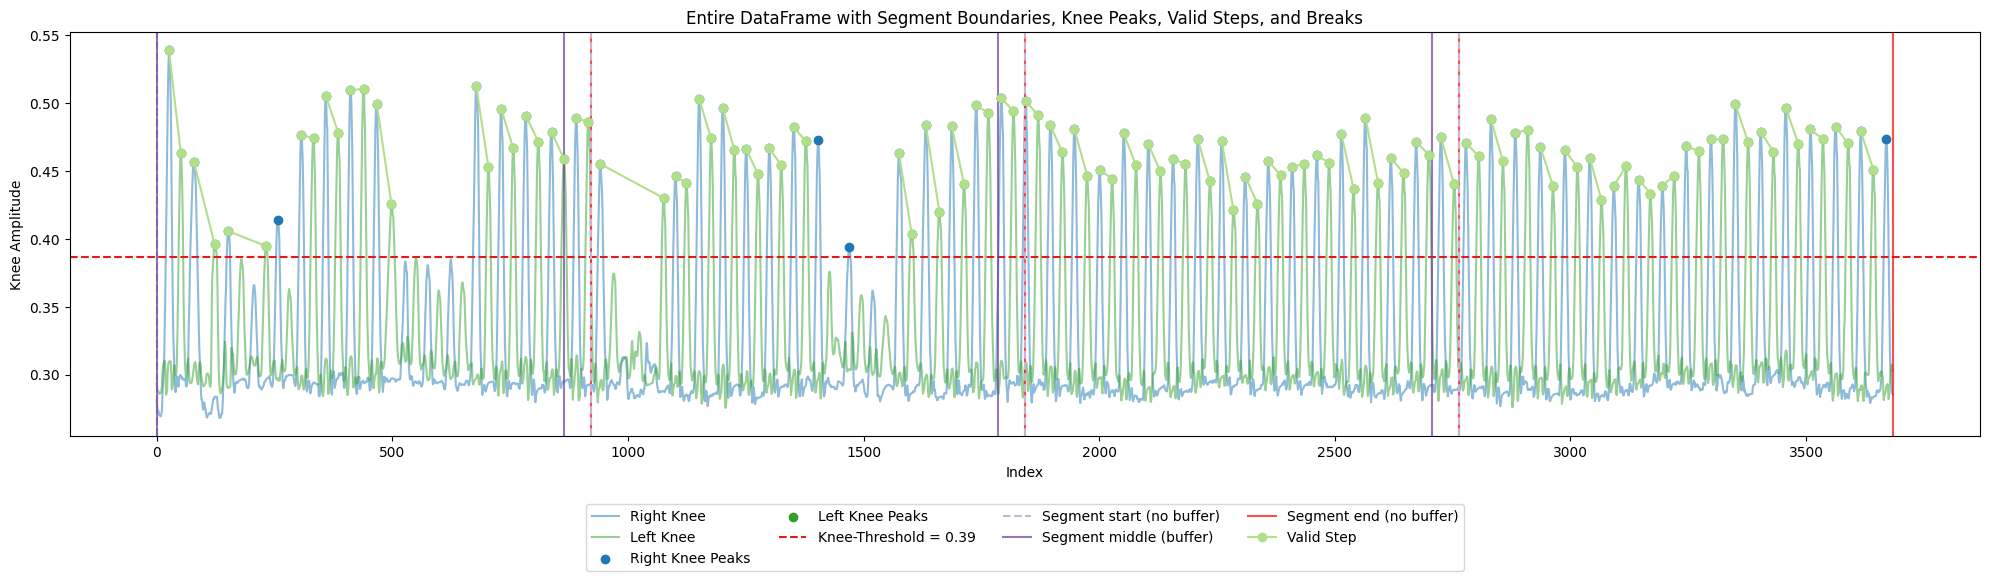

In [44]:
# plot entire dataframe with paired steps
plot_entire_dataframe(df, knee_peaks_right, knee_peaks_left, knee_threshold, segment_indices, valid_steps)

In [45]:
print(f"The list of all valid knee peaks of the left knee that were above the knee-threshold contains {len(knee_peaks_left)} peaks and the list containing all valid peaks of the right knee contains {len(knee_peaks_right)} peaks.")
print("\n")
print(f"There were a total of {valid_step_count} valid steps detected, which indicates that the step detection works perfectly, without counting the unpaired left and right peaks at the start and end.")

The list of all valid knee peaks of the left knee that were above the knee-threshold contains 59 peaks and the list containing all valid peaks of the right knee contains 63 peaks.


There were a total of 59 valid steps detected, which indicates that the step detection works perfectly, without counting the unpaired left and right peaks at the start and end.


This indicates how the buffering system works in tracking 'un-closed' or 'un-paired' steps across segments and displays how the buffering system works. No steps are being counted double, as the plots below indicate where unclosed left knee peaks at the beginning of segments 2, 3 and 4 are closed by an unpaired right knee peak at the end of the previous segment. 

Valid steps with ground contact: 11
11 steps counted with 4 correct arm-leg coordination.


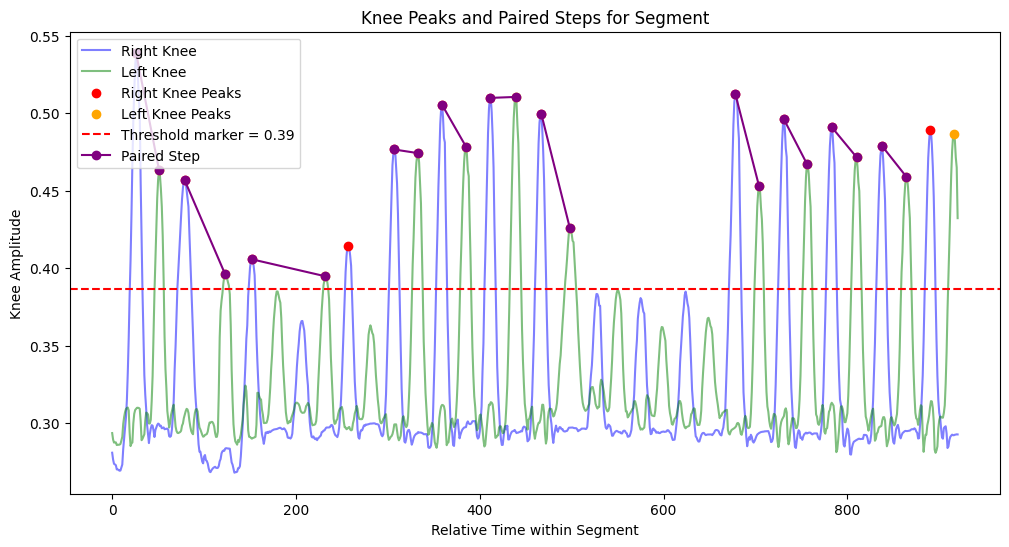

Valid steps with ground contact: 12
12 steps counted with 4 correct arm-leg coordination.


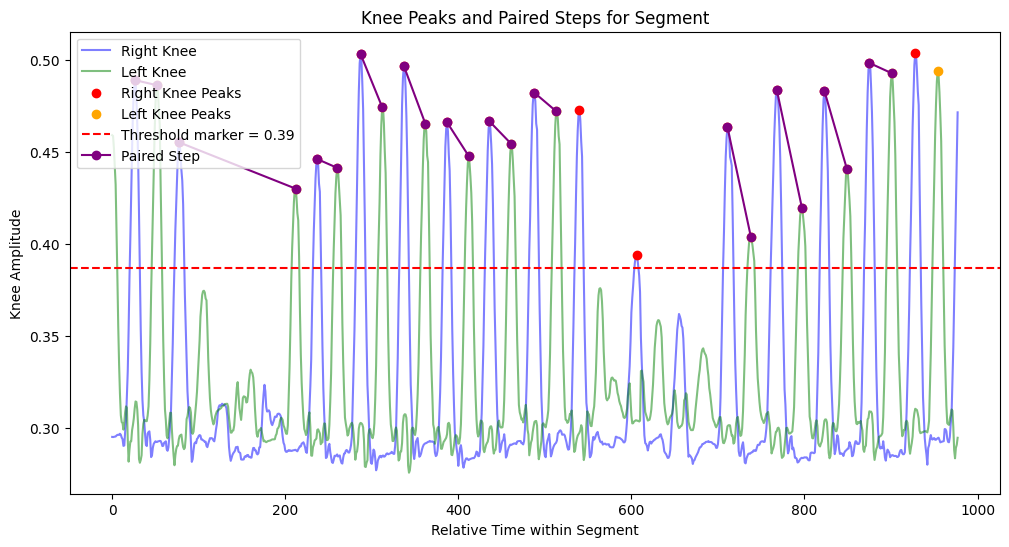

Valid steps with ground contact: 18
18 steps counted with 8 correct arm-leg coordination.


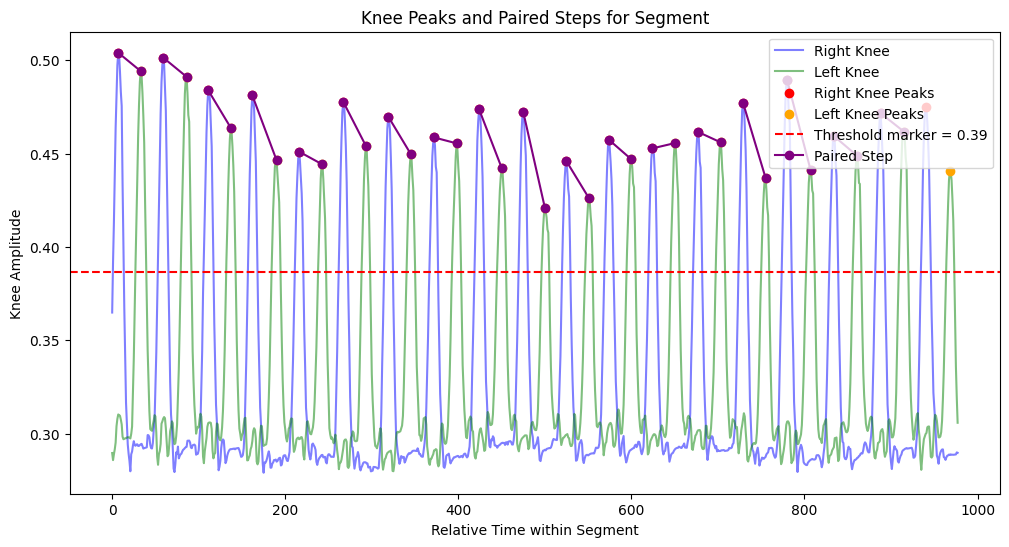

Valid steps with ground contact: 18
18 steps counted with 4 correct arm-leg coordination.


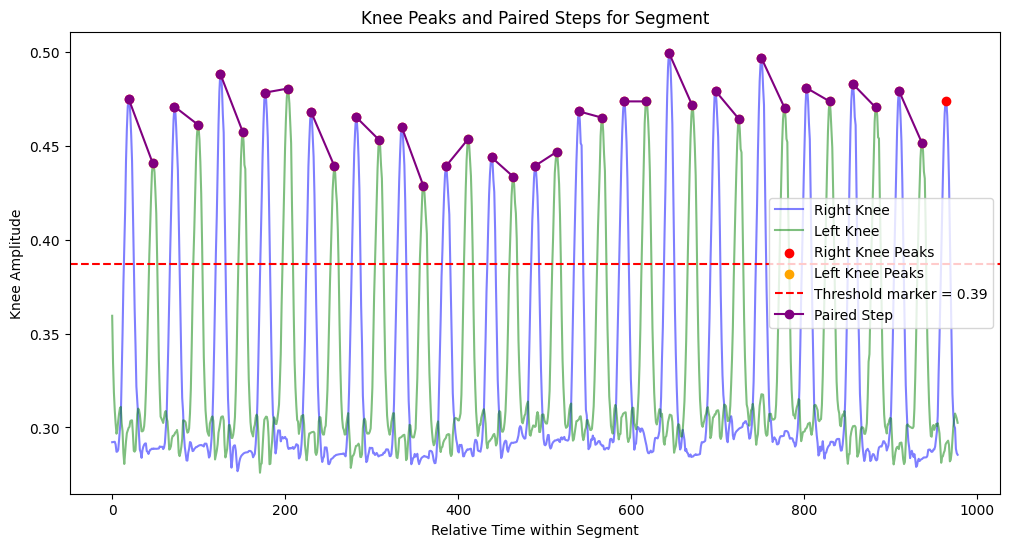

In [46]:
# initialize empty list to store results in
segment_results = []

# and iterate over all four segments to perform the analysis 
for i, segment in enumerate(segments_main):
    
    # set is_last to True for the last segment
    is_last = (i == 3)
    
    # obtain results per segment
    segment_res = analyze_segment(segment, knee_threshold, 30, hand_threshold, is_last=is_last, time_window=200)
    
    # and append results to segment-results-list
    segment_results.append(segment_res)

In [47]:
#segment_results

In [48]:
def compute_consistency_metrics(segment_results):
    
    # compute mean and sd of number steps over all segments
    num_steps = [result['num_steps'] for result in segment_results]
    avg_steps = np.mean(num_steps)
    std_steps = np.std(num_steps)
    
    # compute mean sd of cross-body-coordination over all segments
    correct_coordination = [result['correct_coordination'] for result in segment_results]
    avg_coordination = np.mean(correct_coordination)
    std_coordination = np.std(correct_coordination)
    
    # compute mean and sd of amplitude-variation over all segments
    right_variations = [result['right_variation'] for result in segment_results]
    left_variations = [result['left_variation'] for result in segment_results]
    
    # and obtain mean and sd for rigth knee's amplitudes
    avg_right_variation = np.mean(right_variations)
    std_right_variation = np.std(right_variations)
    
    # and same for left
    avg_left_variation = np.mean(left_variations)
    std_left_variation = np.std(left_variations)
    
    right_times = np.concatenate([result['time_between_right_peaks'] for result in segment_results])
    left_times = np.concatenate([result['time_between_left_peaks'] for result in segment_results])
    
    # and compute mean and sd for time between right knee peaks
    avg_time_right = np.mean(right_times)
    sd_time_right = np.std(right_times)
    
    # ...and left knee peaks
    avg_time_left = np.mean(left_times)
    sd_time_left = np.std(left_times)
    
    #breaks_right = np.concatenate([result['breaks_right_knee'] for result in segment_results])
    #breaks_left = np.concatenate([result['breaks_left_knee'] for result in segment_results])
    
    # and sum all the breaks across segments
    #num_breaks = sum(breaks_right, breaks_left)
    
    # and store everything in a dictionary
    return {
        "knee_threshold": knee_threshold,
        "num_steps": num_steps,
        "mean_steps": avg_steps,
        "sd_steps": std_steps,
        "correct_coordination": correct_coordination,
        "mean_coordination": avg_coordination,
        "sd_coordination": std_coordination,
        "mean_right_variation": avg_right_variation,
        "sd_right_variation": std_right_variation,
        "mean_left_variation": avg_left_variation,
        "sd_left_variation": std_left_variation#,
        #"breaks_taken": num_breaks
    }

In [49]:
# compute consistency metrics over all four segments
consistency_metrics = compute_consistency_metrics(segment_results)

In [50]:
# convert dictionaries to dataframes for saving ...
df_segment_results = pd.DataFrame(segment_results)
df_consistency_metrics = pd.DataFrame([consistency_metrics])

In [51]:
df_segment_results

,num_steps,correct_coordination,right_amplitudes,left_amplitudes,right_variation,left_variation,time_between_right_peaks,time_between_left_peaks,num_breaks,break_frames
0,11,4,"[0.5390207767486572, 0.4565698504447937, 0.405...","[0.4633110761642456, 0.3959627151489258, 0.394...",0.036416,0.033443,"[1.7666666666666666, 2.433333333333333, 3.5, 1...","[2.3999999999999995, 3.6333333333333337, 3.366...",0,[]
1,12,4,"[0.4891548156738281, 0.4553154110908508, 0.446...","[0.4863108992576599, 0.4300675988197326, 0.441...",0.027202,0.027209,"[1.7666666666666666, 2.433333333333333, 3.5, 1...","[2.3999999999999995, 3.6333333333333337, 3.366...",2,"[973, 974, 975, 976, 977, 978, 979, 980, 981, ..."
2,18,8,"[0.5040339827537537, 0.5013966858386993, 0.483...","[0.4941585659980774, 0.491137146949768, 0.4638...",0.015636,0.017630,"[1.7666666666666666, 2.433333333333333, 3.5, 1...","[2.3999999999999995, 3.6333333333333337, 3.366...",0,[]
3,18,4,"[0.4750027656555176, 0.4708180427551269, 0.488...","[0.4405688643455505, 0.4612272977828979, 0.457...",0.016487,0.014718,"[1.7666666666666666, 2.433333333333333, 3.5, 1...","[2.3999999999999995, 3.6333333333333337, 3.366...",0,[]


In [52]:
#  ...to csv
df_segment_results.to_csv('segment_results_1.csv', index=False)
df_consistency_metrics.to_csv('consistency_metrics_1.csv', index=False)

# ... and pickle format
df_segment_results.to_pickle('segment_results_1.pkl')
df_consistency_metrics.to_pickle('consistency_metrics_1.pkl')

And store lists with frame number of knee and hand peaks, breaks and ground contact as df for performance metrics.

In [53]:
# setup empty df filled with zeros for predictiosn
df_pred = pd.DataFrame(0, index=range(len(step_data)), columns=['pred_right_knee', 'pred_left_knee', 
                                                      'pred_left_hand', 'pred_right_hand', 
                                                      'pred_left_ground', 'pred_right_ground', 'breaks'])

In [54]:
df_pred.loc[knee_peaks_right, 'pred_right_knee'] = 1
df_pred.loc[knee_peaks_left, 'pred_left_knee'] = 1
df_pred.loc[peaks_left_hand, 'pred_left_hand'] = 1
df_pred.loc[peaks_right_hand, 'pred_right_hand'] = 1
df_pred.loc[ground_contact_left, 'pred_left_ground'] = 1
df_pred.loc[ground_contact_right, 'pred_right_ground'] = 1

In [55]:
df_pred.to_csv("predictions_1.csv", index=False)